In [503]:
library(forecast)
library(ggplot2)
library(dplyr)

In [504]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()

### ЕС

In [505]:
df_eu  <-  read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [506]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [507]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)


In [508]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, 
                         method = "ML" )
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2000.00 2011.75 2012.00 2013.75
[1] 2001.00 2012.75 2013.00 2014.75
[1] 2002.00 2013.75 2014.00 2015.75
[1] 2003.00 2014.75 2015.00 2016.75
[1] 2004.00 2015.75 2016.00 2017.75
[1] 2005.00 2016.75 2017.00 2018.75


In [509]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-25.10788,39.79210,1.0469576
-19.10680,30.64221,0.8587702
56.58739,73.48258,1.7092086
60.65981,66.00735,1.8157914
-63.86244,71.66316,1.9413245
85.23901,89.44994,2.4512776


In [510]:
colMeans(df_acc_test)

ME      RMSE      MAPE 
15.734847 61.839556  1.637222

In [511]:
m_top

[[1]]
Series: train 
ARIMA(3,0,0)(2,0,0)[4] with drift 

Coefficients:
         ar1      ar2      ar3    sar1     sar2  intercept    drift
      1.3186  -0.4218  -0.1277  0.8975  -0.0058  2142.1276  17.9839
s.e.  0.1673   0.2763   0.1607  0.1775   0.1874   147.5116   3.8801

sigma^2 estimated as 1061:  log likelihood=-235.56
AIC=487.13   AICc=490.82   BIC=502.1

[[2]]
Series: train 
ARIMA(3,0,0)(2,0,0)[4] with drift 

Coefficients:
         ar1      ar2      ar3    sar1     sar2  intercept    drift
      1.3208  -0.4361  -0.1179  0.9003  -0.0148  2224.7504  17.5114
s.e.  0.1733   0.2877   0.1662  0.1775   0.1853   144.0264   3.8421

sigma^2 estimated as 1075:  log likelihood=-235.79
AIC=487.57   AICc=491.27   BIC=502.54

[[3]]
Series: train 
ARIMA(3,0,0)(2,0,0)[4] with drift 

Coefficients:
         ar1      ar2      ar3    sar1    sar2  intercept    drift
      1.3205  -0.4308  -0.1132  0.8513  0.0559  2309.7265  16.8248
s.e.  0.1641   0.2687   0.1566  0.1768  0.1826   164.5624   4.06

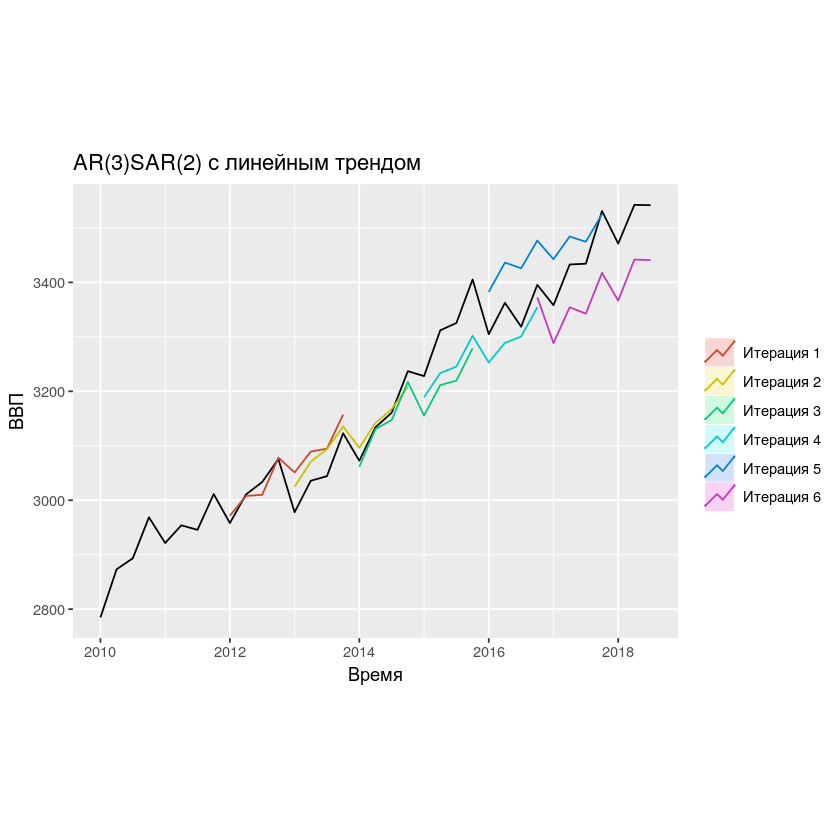

In [512]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [513]:
save_plots  <- list()

In [514]:
save_plots[[1]]  <-  plot_forecasts

In [515]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

In [516]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, 
                         method = "ML" )
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2000.00 2011.75 2012.00 2013.75
[1] 2000.25 2012.00 2012.25 2014.00
[1] 2000.50 2012.25 2012.50 2014.25
[1] 2000.75 2012.50 2012.75 2014.50
[1] 2001.00 2012.75 2013.00 2014.75
[1] 2001.25 2013.00 2013.25 2015.00
[1] 2001.50 2013.25 2013.50 2015.25
[1] 2001.75 2013.50 2013.75 2015.50
[1] 2002.00 2013.75 2014.00 2015.75
[1] 2002.25 2014.00 2014.25 2016.00
[1] 2002.50 2014.25 2014.50 2016.25
[1] 2002.75 2014.50 2014.75 2016.50
[1] 2003.00 2014.75 2015.00 2016.75
[1] 2003.25 2015.00 2015.25 2017.00
[1] 2003.50 2015.25 2015.50 2017.25
[1] 2003.75 2015.50 2015.75 2017.50
[1] 2004.00 2015.75 2016.00 2017.75
[1] 2004.25 2016.00 2016.25 2018.00
[1] 2004.50 2016.25 2016.50 2018.25
[1] 2004.75 2016.50 2016.75 2018.50


In [517]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-25.107882,39.79210,1.0469576
-12.823019,33.87193,1.0445152
-43.097412,51.21071,1.5324912
-65.726650,69.18184,2.1458028
-19.106801,30.64221,0.8587702
64.565718,72.16927,2.0441507
35.842511,58.27388,1.3032803
84.524415,94.20491,2.6135538
56.587387,73.48258,1.7092086
52.633300,69.73507,1.6829899


In [518]:
colMeans(df_acc_test)

ME      RMSE      MAPE 
19.177640 60.484282  1.621391

In [519]:
df_1  <-  data.frame(l[[1]]$mean)
for (i in 2:length(l)){
    df_1  <- cbind(df_1, data.frame(l[[i]]$mean))
}

df_1  <- t(df_1)
colnames(df_1) <- seq(1:dim(df_1)[2])
rownames(df_1) <- seq(1:dim(df_1)[1])

In [520]:
save_fcsts  <- list()

In [521]:
save_fcsts[[1]] <- df_1

#### Poly Trend

In [522]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)

In [523]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    t <- 1:length(train)
    regressors <- cbind(trend=t,quad=t^2)
        
    m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, xreg = regressors, include.drift = FALSE, include.mean = TRUE, method = "ML")
    
    t_f <- (length(train)+1):(length(train)+var_h)
    regressors_f <- cbind(trend=t_f,quad=t_f^2)
    
    l[[k]]  <-   forecast(m_top[[k]], h = var_h, xreg = regressors_f  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2000.00 2011.75 2012.00 2013.75
[1] 2001.00 2012.75 2013.00 2014.75
[1] 2002.00 2013.75 2014.00 2015.75
[1] 2003.00 2014.75 2015.00 2016.75
[1] 2004.00 2015.75 2016.00 2017.75
[1] 2005.00 2016.75 2017.00 2018.75


In [524]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
33.57291,43.09295,1.190258
41.31055,70.14746,1.800424
111.21447,135.53675,3.369613
102.56120,106.16113,3.067016
-70.09599,76.15499,2.083035
97.05184,102.44217,2.789127


In [525]:
colMeans(df_acc_test)

ME      RMSE      MAPE 
52.602496 88.922573  2.383245

In [526]:
m_top

[[1]]
Series: train 
Regression with ARIMA(3,0,0)(2,0,0)[4] errors 

Coefficients:
         ar1      ar2      ar3    sar1    sar2  intercept    trend     quad
      1.2836  -0.3731  -0.1593  0.8807  0.0048  2095.2416  28.2421  -0.2089
s.e.  0.1719   0.2809   0.1635  0.1707  0.1800   137.7814   9.2673   0.1750

sigma^2 estimated as 1067:  log likelihood=-234.91
AIC=487.83   AICc=492.57   BIC=504.67

[[2]]
Series: train 
Regression with ARIMA(3,0,0)(2,0,0)[4] errors 

Coefficients:
         ar1      ar2      ar3    sar1     sar2  intercept    trend     quad
      1.3042  -0.4171  -0.1359  0.8867  -0.0042  2177.7516  27.8843  -0.2123
s.e.  0.1752   0.2888   0.1674  0.1714   0.1793   137.4014   9.3467   0.1767

sigma^2 estimated as 1077:  log likelihood=-235.12
AIC=488.23   AICc=492.97   BIC=505.07

[[3]]
Series: train 
Regression with ARIMA(3,0,0)(2,0,0)[4] errors 

Coefficients:
         ar1      ar2      ar3    sar1    sar2  intercept    trend     quad
      1.2975  -0.4049  -0.1375  0.

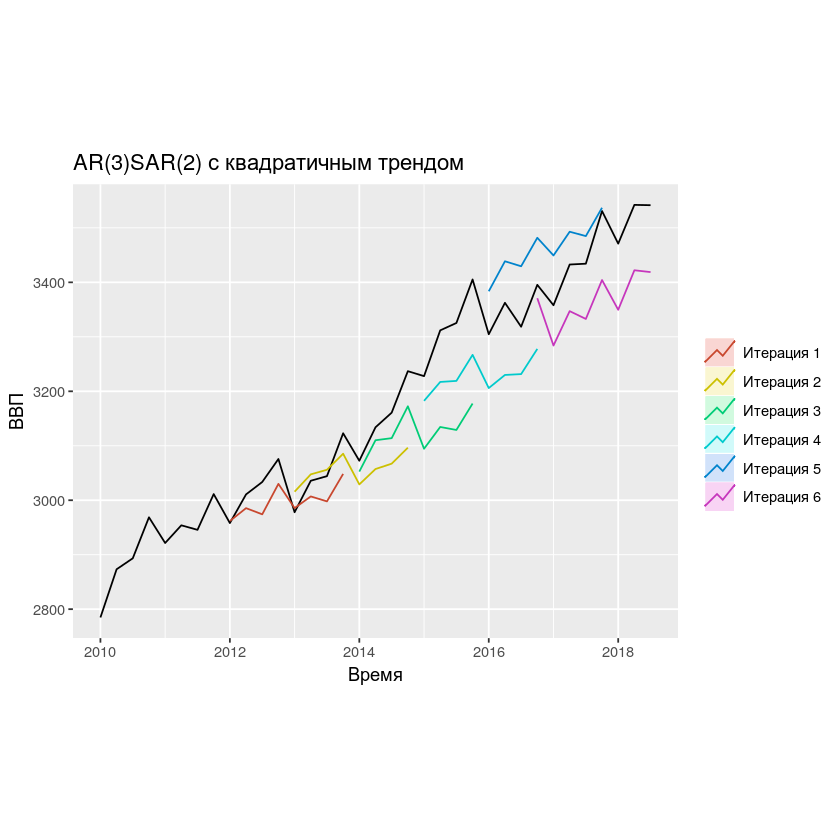

In [527]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с квадратичным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [528]:
save_plots[[2]]  <- plot_forecasts

In [529]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)

In [530]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    t <- 1:length(train)
    regressors <- cbind(trend=t,quad=t^2)
        
    m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, xreg = regressors, include.drift = FALSE, include.mean = TRUE, method = "ML")
    
    t_f <- (length(train)+1):(length(train)+var_h)
    regressors_f <- cbind(trend=t_f,quad=t_f^2)
    
    l[[k]]  <-   forecast(m_top[[k]], h = var_h, xreg = regressors_f  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2000.00 2011.75 2012.00 2013.75
[1] 2000.25 2012.00 2012.25 2014.00
[1] 2000.50 2012.25 2012.50 2014.25
[1] 2000.75 2012.50 2012.75 2014.50
[1] 2001.00 2012.75 2013.00 2014.75
[1] 2001.25 2013.00 2013.25 2015.00
[1] 2001.50 2013.25 2013.50 2015.25
[1] 2001.75 2013.50 2013.75 2015.50
[1] 2002.00 2013.75 2014.00 2015.75
[1] 2002.25 2014.00 2014.25 2016.00
[1] 2002.50 2014.25 2014.50 2016.25
[1] 2002.75 2014.50 2014.75 2016.50
[1] 2003.00 2014.75 2015.00 2016.75
[1] 2003.25 2015.00 2015.25 2017.00
[1] 2003.50 2015.25 2015.50 2017.25
[1] 2003.75 2015.50 2015.75 2017.50
[1] 2004.00 2015.75 2016.00 2017.75
[1] 2004.25 2016.00 2016.25 2018.00
[1] 2004.50 2016.25 2016.50 2018.25
[1] 2004.75 2016.50 2016.75 2018.50


In [531]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
33.572907,43.09295,1.1902577
53.996528,59.81262,1.7624790
9.080431,30.30227,0.8413238
-30.226584,45.49474,1.3099042
41.310549,70.14746,1.8004236
126.690894,142.57117,4.0062811
94.798167,121.78173,3.0500762
153.750024,173.46306,4.7474645
111.214465,135.53675,3.3696131
93.083660,114.76524,2.8462253


In [532]:
colMeans(df_acc_test)

ME      RMSE      MAPE 
59.350313 86.673502  2.323167

In [533]:
df_1  <-  data.frame(l[[1]]$mean)
for (i in 2:length(l)){
    df_1  <- cbind(df_1, data.frame(l[[i]]$mean))
}

df_1  <- t(df_1)
colnames(df_1) <- seq(1:dim(df_1)[2])
rownames(df_1) <- seq(1:dim(df_1)[1])

In [534]:
save_fcsts[[2]] <- df_1

In [535]:
library(multDM)

In [536]:
list_dm <- list()
dm_stat  <-  c()
for (i in 1:dim(df_1)[2]){
    
    wind  <-  window(gdp_agg, start=(var_start_year + 1/var_freq*(var_window+i)), end=(var_start_year + 1/var_freq*(var_window+i-1+dim(df_1)[1])))
    
    list_dm[[i]]  <- DM.test(f1=save_fcsts[[1]][,i],f2=save_fcsts[[2]][,i],y=wind,loss.type="SPE",h=i,c=TRUE,H1="same")
    dm_stat  <-  c(dm_stat,list_dm[[i]][[1]][[1]])
}

In [537]:
data_dm  <- cbind(dm_stat, seq(1,var_h))

colnames(data_dm)  <-  c('DM','h')

data_dm  <- as.data.frame(data_dm)

In [538]:
var_col_test  <-  'red'

In [539]:
var_95 <- qt(c(.025, .975), df = dim(df_acc_test)[1] - 1)
var_90  <- qt(c(.05, .95), df = dim(df_acc_test)[1] - 1)

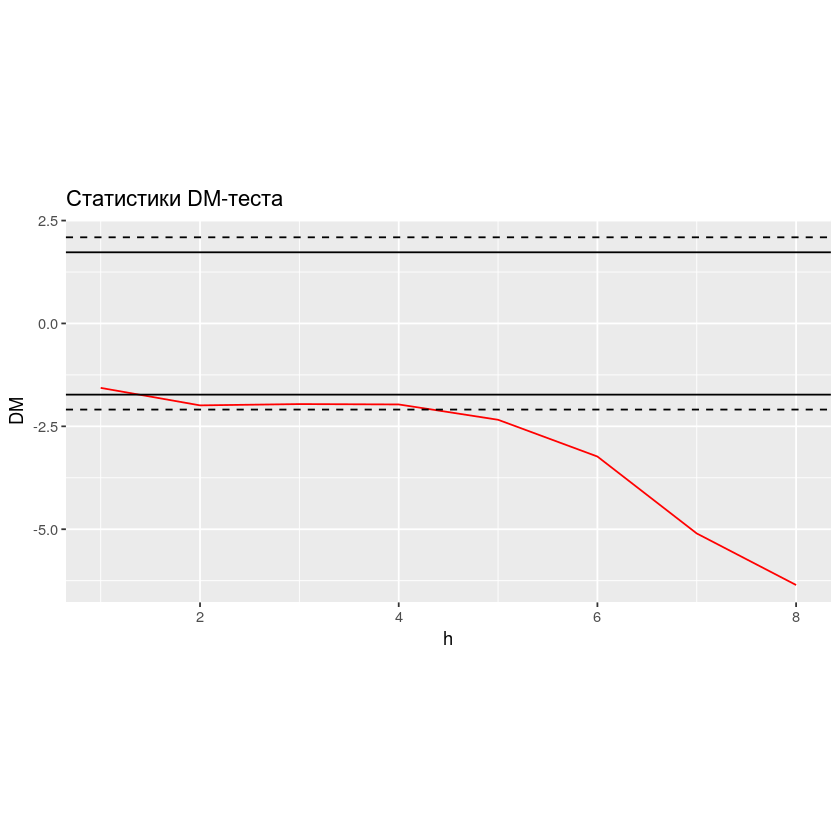

In [540]:
# plot_dm <- 

ggplot(data=data_dm, aes(x=h, y=DM)) +
            geom_line(colour=var_col_test) + labs(title = "Статистики DM-теста")  +
            theme(aspect.ratio = 0.5)+
            labs(y = "DM", x = 'h') +
            geom_hline(yintercept=var_95, linetype="dashed", color = "black") +
            geom_hline(yintercept=var_90,  color = "black") 
            

### США

In [541]:
df_eu  <-  read.csv(file="hts_us_ind_filled.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2005   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [542]:
var_h  <- 8
var_window  <-  28 - 1
var_topup  <-  2
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [543]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,0,0)


In [544]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    m_top[[k]]  <- Arima(train, order=var_arpdq, include.drift = TRUE, include.mean = TRUE, 
                         method = "ML" )
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2005.00 2011.75 2012.00 2013.75
[1] 2006.00 2012.75 2013.00 2014.75
[1] 2007.00 2013.75 2014.00 2015.75
[1] 2008.00 2014.75 2015.00 2016.75
[1] 2009.00 2015.75 2016.00 2017.75
[1] 2010.00 2016.75 2017.00 2018.75


In [545]:
m_top

[[1]]
Series: train 
ARIMA(4,0,0) with drift 

Coefficients:
         ar1      ar2      ar3      ar4   intercept    drift
      1.0668  -0.0391  -0.1468  -0.1335  15057.0415  22.7681
s.e.  0.1943   0.2970   0.2958   0.1968    167.8451  10.2649

sigma^2 estimated as 11940:  log likelihood=-168.85
AIC=351.71   AICc=357.31   BIC=361.03

[[2]]
Series: train 
ARIMA(4,0,0) with drift 

Coefficients:
         ar1      ar2      ar3      ar4  intercept    drift
      1.0948  -0.0732  -0.1881  -0.0749  15277.282  17.2398
s.e.  0.1837   0.2767   0.2757   0.1877    143.599   8.8096

sigma^2 estimated as 10648:  log likelihood=-167.2
AIC=348.4   AICc=354   BIC=357.73

[[3]]
Series: train 
ARIMA(4,0,0) with drift 

Coefficients:
         ar1      ar2      ar3      ar4   intercept    drift
      1.1427  -0.1105  -0.1306  -0.0974  15161.5604  34.9609
s.e.  0.1865   0.2860   0.2884   0.2022    187.9171  10.9177

sigma^2 estimated as 11986:  log likelihood=-168.95
AIC=351.9   AICc=357.5   BIC=361.23

[[

In [546]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
213.07708,271.2988,1.3144929
562.04203,627.1262,3.4013339
440.52784,531.1201,2.7251061
440.38571,464.5928,2.5532233
115.18035,124.9120,0.6547241
75.86932,105.1010,0.4354289


In [547]:
colMeans(df_acc_test)

ME       RMSE       MAPE 
307.847056 354.025136   1.847385

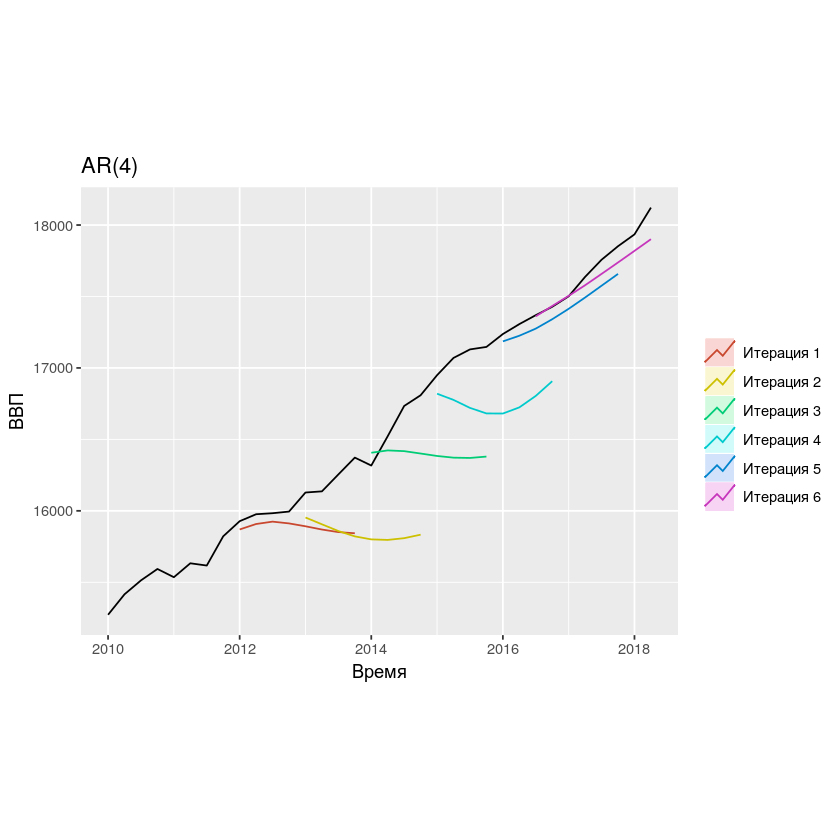

In [548]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(4)") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [549]:
save_plots[[3]]  <-  plot_forecasts

In [550]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

In [551]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, 
                         method = "ML" )
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2005.00 2011.75 2012.00 2013.75
[1] 2005.25 2012.00 2012.25 2014.00
[1] 2005.50 2012.25 2012.50 2014.25
[1] 2005.75 2012.50 2012.75 2014.50
[1] 2006.00 2012.75 2013.00 2014.75
[1] 2006.25 2013.00 2013.25 2015.00
[1] 2006.50 2013.25 2013.50 2015.25
[1] 2006.75 2013.50 2013.75 2015.50
[1] 2007.00 2013.75 2014.00 2015.75
[1] 2007.25 2014.00 2014.25 2016.00
[1] 2007.50 2014.25 2014.50 2016.25
[1] 2007.75 2014.50 2014.75 2016.50
[1] 2008.00 2014.75 2015.00 2016.75
[1] 2008.25 2015.00 2015.25 2017.00
[1] 2008.50 2015.25 2015.50 2017.25
[1] 2008.75 2015.50 2015.75 2017.50
[1] 2009.00 2015.75 2016.00 2017.75
[1] 2009.25 2016.00 2016.25 2018.00
[1] 2009.50 2016.25 2016.50 2018.25


In [552]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
213.6660,279.3741,1.3174944
245.0399,321.0685,1.5252327
339.6054,416.1809,2.1033105
481.3469,546.8620,2.9309418
558.4914,621.0522,3.3802364
428.4656,527.2255,2.5650350
540.6488,620.3988,3.2208701
485.9341,575.3735,2.8721117
450.9589,539.5808,2.7739953
675.1245,713.8963,3.9653460


In [553]:
colMeans(df_acc_test)

ME       RMSE       MAPE 
379.659427 432.602136   2.251367

In [554]:
df_1  <-  data.frame(l[[1]]$mean)
for (i in 2:length(l)){
    df_1  <- cbind(df_1, data.frame(l[[i]]$mean))
}

df_1  <- t(df_1)
colnames(df_1) <- seq(1:dim(df_1)[2])
rownames(df_1) <- seq(1:dim(df_1)[1])

In [555]:
save_fcsts  <- list()

In [556]:
save_fcsts[[1]] <- df_1

#### Poly Trend

In [557]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,0,0)
# var_sarpdq   <-  c(2,0,0)

In [558]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    t <- 1:length(train)
    regressors <- cbind(trend=t,quad=t^2)
        
    m_top[[k]]  <- Arima(train, order=var_arpdq, xreg = regressors, include.drift = FALSE, include.mean = TRUE, method = "ML")
    
    t_f <- (length(train)+1):(length(train)+var_h)
    regressors_f <- cbind(trend=t_f,quad=t_f^2)
    
    l[[k]]  <-   forecast(m_top[[k]], h = var_h, xreg = regressors_f  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2005.00 2011.75 2012.00 2013.75
[1] 2006.00 2012.75 2013.00 2014.75
[1] 2007.00 2013.75 2014.00 2015.75
[1] 2008.00 2014.75 2015.00 2016.75
[1] 2009.00 2015.75 2016.00 2017.75
[1] 2010.00 2016.75 2017.00 2018.75


In [559]:
m_top

[[1]]
Series: train 
Regression with ARIMA(4,0,0) errors 

Coefficients:
         ar1      ar2      ar3      ar4   intercept    trend     quad
      1.0585  -0.0325  -0.1499  -0.1324  15012.6517  32.4662  -0.3384
s.e.  0.1966   0.2976   0.2956   0.1969    230.0099  36.1103   1.2002

sigma^2 estimated as 12489:  log likelihood=-168.81
AIC=353.63   AICc=361.21   BIC=364.29

[[2]]
Series: train 
Regression with ARIMA(4,0,0) errors 

Coefficients:
         ar1      ar2     ar3      ar4   intercept     trend    quad
      0.9749  -0.0341  -0.193  -0.1434  15584.0603  -43.0192  2.0155
s.e.  0.1852   0.2617   0.259   0.1873    160.3874   25.5680  0.8411

sigma^2 estimated as 9875:  log likelihood=-165.45
AIC=346.91   AICc=354.49   BIC=357.56

[[3]]
Series: train 
Regression with ARIMA(4,0,0) errors 

Coefficients:
         ar1      ar2      ar3      ar4   intercept     trend    quad
      0.8402  -0.0349  -0.1810  -0.2109  15669.7922  -66.9606  3.4225
s.e.  0.1807   0.2406   0.2411   0.1888  

In [560]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
296.1883,363.0917,1.8284877
120.7061,131.2946,0.7338990
-310.8354,329.6562,1.8383374
-199.0540,250.6441,1.1496272
-147.2344,171.7987,0.8358859
-198.0711,205.7457,1.1166071


In [561]:
colMeans(df_acc_test)

ME       RMSE       MAPE 
-73.050091 242.038513   1.250474

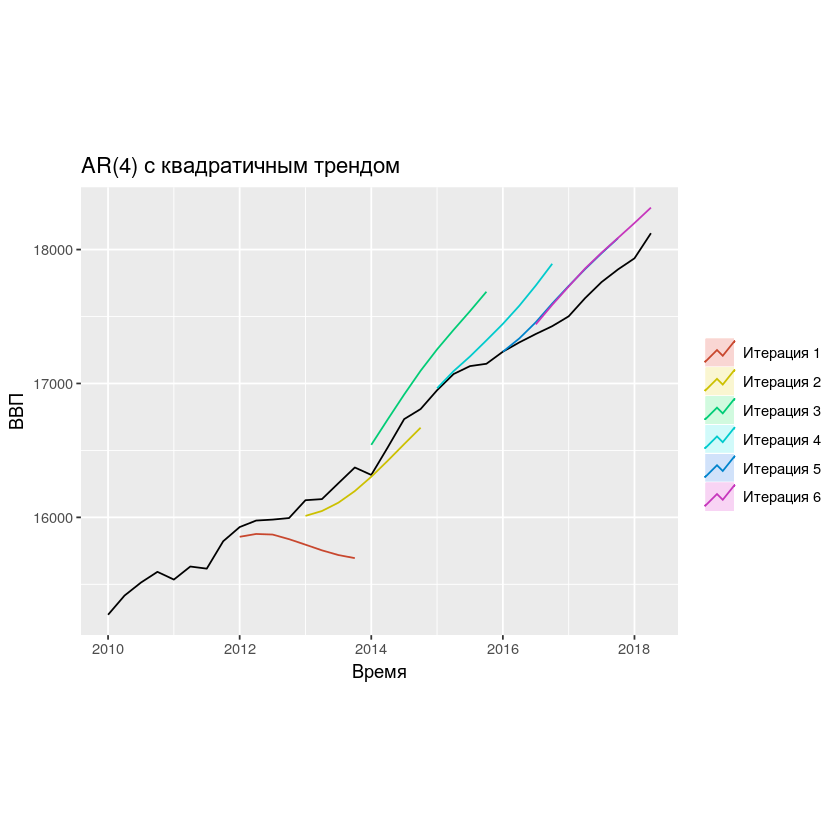

In [562]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(4) с квадратичным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [563]:
save_plots[[4]]  <- plot_forecasts

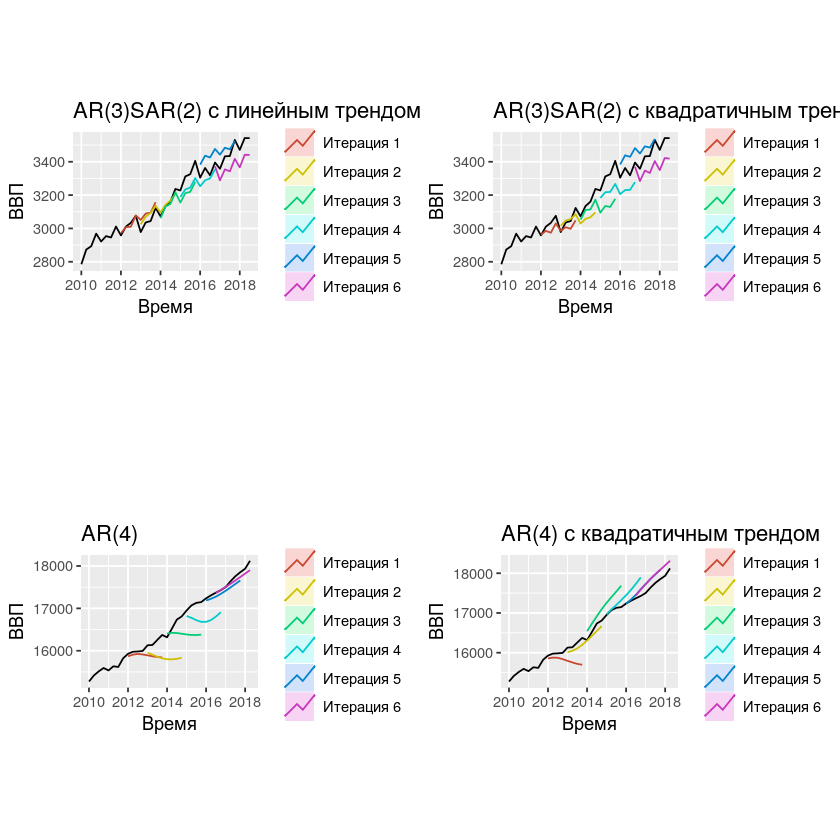

In [564]:
library(gridExtra)
grid.arrange(grobs = save_plots, ncol = 2)

In [566]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

var_arpdq   <-  c(4,0,0)
# var_sarpdq   <-  c(2,0,0)

In [567]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    t <- 1:length(train)
    regressors <- cbind(trend=t,quad=t^2)
        
    m_top[[k]]  <- Arima(train, order=var_arpdq, xreg = regressors, include.drift = FALSE, include.mean = TRUE, method = "ML")
    
    t_f <- (length(train)+1):(length(train)+var_h)
    regressors_f <- cbind(trend=t_f,quad=t_f^2)
    
    l[[k]]  <-   forecast(m_top[[k]], h = var_h, xreg = regressors_f  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2005.00 2011.75 2012.00 2013.75
[1] 2005.25 2012.00 2012.25 2014.00
[1] 2005.50 2012.25 2012.50 2014.25
[1] 2005.75 2012.50 2012.75 2014.50
[1] 2006.00 2012.75 2013.00 2014.75
[1] 2006.25 2013.00 2013.25 2015.00
[1] 2006.50 2013.25 2013.50 2015.25
[1] 2006.75 2013.50 2013.75 2015.50
[1] 2007.00 2013.75 2014.00 2015.75
[1] 2007.25 2014.00 2014.25 2016.00
[1] 2007.50 2014.25 2014.50 2016.25
[1] 2007.75 2014.50 2014.75 2016.50
[1] 2008.00 2014.75 2015.00 2016.75
[1] 2008.25 2015.00 2015.25 2017.00
[1] 2008.50 2015.25 2015.50 2017.25
[1] 2008.75 2015.50 2015.75 2017.50
[1] 2009.00 2015.75 2016.00 2017.75
[1] 2009.25 2016.00 2016.25 2018.00
[1] 2009.50 2016.25 2016.50 2018.25


In [568]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
296.18827,363.0917,1.8284877
176.05678,247.3671,1.1501723
204.83060,262.9943,1.3169677
299.44431,343.9071,1.8227257
120.70605,131.2946,0.7338990
-156.01333,169.8511,0.9428514
-136.37723,158.5557,0.8191842
-301.72073,321.3535,1.7941963
-310.83544,329.6562,1.8383374
-84.32619,187.8572,0.8440385


In [569]:
colMeans(df_acc_test)

ME        RMSE        MAPE 
-105.096793  261.069899    1.328826

In [570]:
df_1  <-  data.frame(l[[1]]$mean)
for (i in 2:length(l)){
    df_1  <- cbind(df_1, data.frame(l[[i]]$mean))
}

df_1  <- t(df_1)
colnames(df_1) <- seq(1:dim(df_1)[2])
rownames(df_1) <- seq(1:dim(df_1)[1])

In [571]:
save_fcsts[[2]] <- df_1

In [572]:
library(multDM)

In [573]:
list_dm <- list()
dm_stat  <-  c()
for (i in 1:dim(df_1)[2]){
    
    wind  <-  window(gdp_agg, start=(var_start_year + 1/var_freq*(var_window+i)), end=(var_start_year + 1/var_freq*(var_window+i-1+dim(df_1)[1])))
    
    list_dm[[i]]  <- DM.test(f1=save_fcsts[[1]][,i],f2=save_fcsts[[2]][,i],y=wind,loss.type="SPE",h=i,c=TRUE,H1="same")
    dm_stat  <-  c(dm_stat,list_dm[[i]][[1]][[1]])
}

In [574]:
data_dm  <- cbind(dm_stat, seq(1,var_h))

colnames(data_dm)  <-  c('DM','h')

data_dm  <- as.data.frame(data_dm)

In [575]:
var_col_test  <-  'red'

In [576]:
var_95 <- qt(c(.025, .975), df = dim(df_acc_test)[1] - 1)
var_90  <- qt(c(.05, .95), df = dim(df_acc_test)[1] - 1)

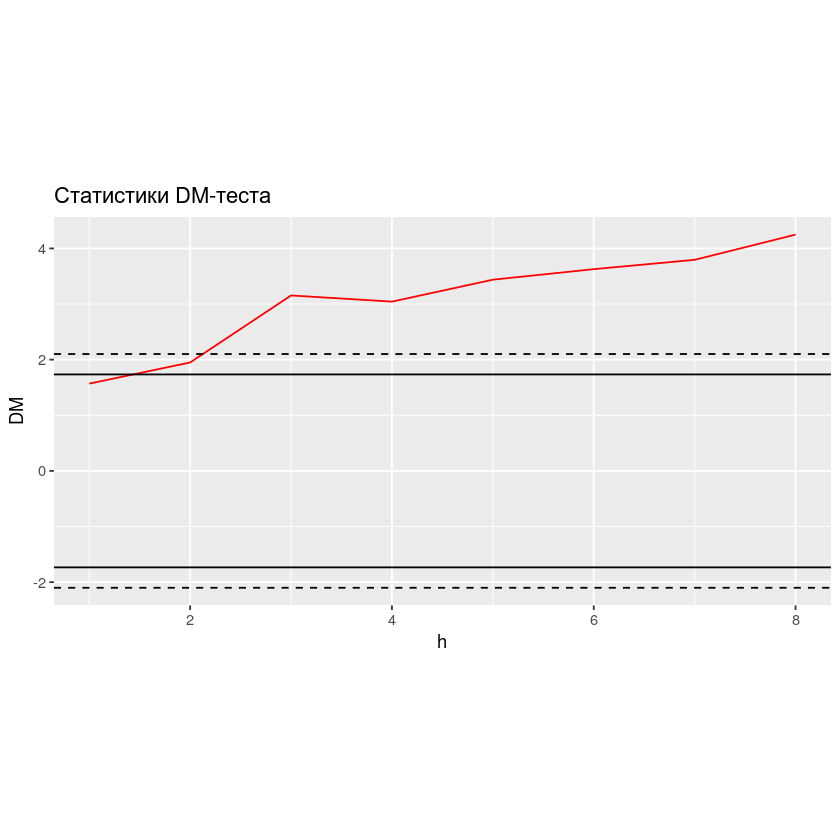

In [577]:
# plot_dm <- 

ggplot(data=data_dm, aes(x=h, y=DM)) +
            geom_line(colour=var_col_test) + labs(title = "Статистики DM-теста")  +
            theme(aspect.ratio = 0.5)+
            labs(y = "DM", x = 'h') +
            geom_hline(yintercept=var_95, linetype="dashed", color = "black") +
            geom_hline(yintercept=var_90,  color = "black") 
            

### РФ

In [633]:
df_eu  <-  read.csv(file="hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [634]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

### Top Level: AR(3)

In [635]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(11,0,0)
var_sarpdq   <-  c(2,0,0)


In [636]:
require(svMisc)

In [637]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0
err_list  <- c()
for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
#         if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#             train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
#         }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
#     }
}
    
#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         test <- window(gdp_agg, start=test_start-var_topup/var_freq)
#     }else{    
        test <- window(gdp_agg, start=test_start, end=test_end)
        
#     }
    
    model  <-  tryCatch( list(Arima(train, order=c(11,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.constant = TRUE, method = "ML") , 0), 
            error = function(e) 
               {tryCatch( list( Arima(train, order=c(11,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.constant = TRUE, method = "CSS"), i+1), 
                         error = function(e)              
                            list( Arima(train, order=c(11,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.constant = TRUE, method = "CSS", optim.method = "CG"), i+1))
                         }
    )

    
    m_top[[k]]  <- model[[1]]
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )
                
    if (model[[2]]!=0){
        err_list <-  c(err_list,model[[2]])
    }              
                
                
    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
                
    progress(i, progress.bar = TRUE)
    
                
    }

          0%---------25%---------50%---------75%--------100%
Progress: ||

In [638]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-11116.729,13183.367,565.6800
-11353.609,12895.546,292.9596
-7247.991,9981.054,141.2119
-16003.477,18934.567,303.0644
-15366.794,17251.270,191.0726


In [639]:
colMeans(df_acc_test)

ME        RMSE        MAPE 
-12217.7200  14449.1609    298.7977

In [640]:
err_list

[1] 3 4

In [641]:
l_test

[[1]]
        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2013 -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
2014 -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
        Nov    Dec
2013   5839    263
2014    438  -2700

[[2]]
        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2014 -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
2015 -25453 -12145 -14835  -7712  -5673   4497  26076  23541  18543  14250
        Nov    Dec
2014    438  -2700
2015   3448   8186

[[3]]
        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2015 -25453 -12145 -14835  -7712  -5673   4497  26076  23541  18543  14250
2016 -27719  -7767    834  -3050  -3848   9358  18466  21879   9990   2149
        Nov    Dec
2015   3448   8186
2016  -1754 -13195

[[4]]
        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2016 -27719  -7767    834  -3050  -3848   9358  1846

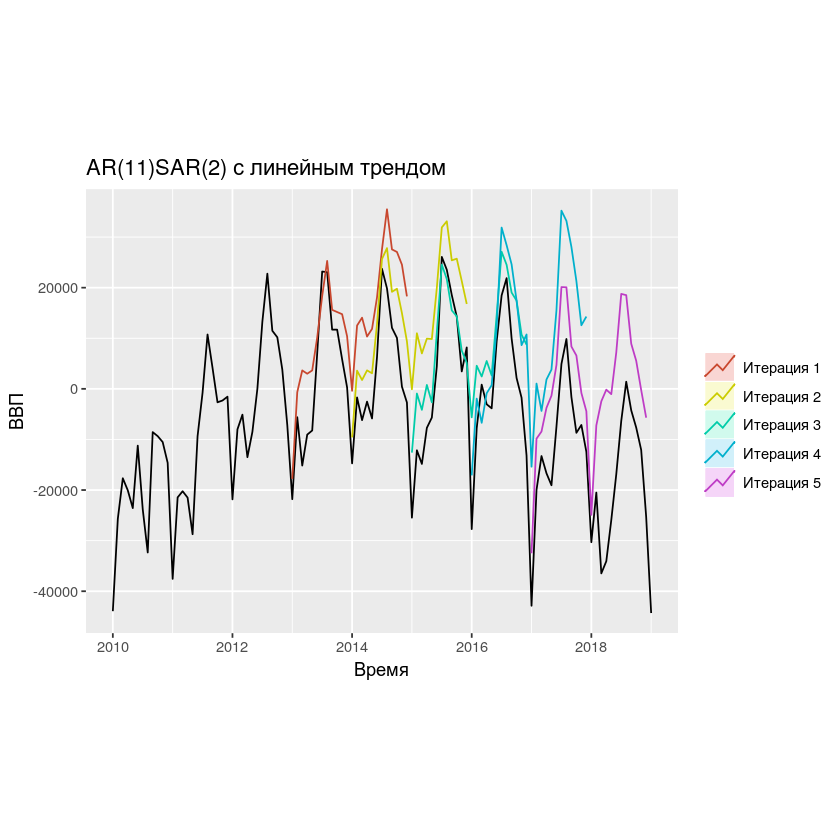

In [642]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ЕП') +
    ggtitle("AR(11)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [643]:
save_plots[[5]]  <-  plot_forecasts

In [644]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

In [645]:
l <- ac <- m_top  <- l_test  <-  list()
err_list  <- c()
k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
   model  <-  tryCatch( list(Arima(train, order=c(11,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.constant = TRUE, method = "ML") , 0), 
            error = function(e) 
               {tryCatch( list( Arima(train, order=c(11,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.constant = TRUE, method = "CSS"), i+1), 
                         error = function(e)              
                            list( Arima(train, order=c(11,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.constant = TRUE, method = "CSS", optim.method = "CG"), i+1))
                         }
    )

    
    m_top[[k]]  <- model[[1]]
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )
                
    if (model[[2]]!=0){
        err_list <-  c(err_list,model[[2]])
    }              
                
                
    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
                
    progress(i, progress.bar = TRUE)
    
                
    }

          0%---------25%---------50%---------75%--------100%
Progress: ||||||||||||||||||||||||

In [646]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-11116.7286,13183.367,565.6800
-10196.8272,13014.551,489.2421
-10673.1915,13643.164,469.3939
-8261.5042,12125.635,349.9285
-9273.0919,12904.052,362.8138
-8852.9588,12848.536,359.8287
-10687.3224,13628.631,388.5538
-11895.1215,14017.417,388.5188
-11379.4037,13600.925,372.9155
-11486.4100,13618.870,365.2913


In [647]:
colMeans(df_acc_test)

ME        RMSE        MAPE 
-11656.1699  14613.7858    267.4631

In [648]:
df_1  <-  data.frame(l[[1]]$mean)
for (i in 2:length(l)){
    df_1  <- cbind(df_1, data.frame(l[[i]]$mean))
}

df_1  <- t(df_1)
colnames(df_1) <- seq(1:dim(df_1)[2])
rownames(df_1) <- seq(1:dim(df_1)[1])

In [649]:
save_fcsts  <- list()

save_fcsts[[1]] <- df_1

#### Poly Trend

In [650]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(11,0,0)
var_sarpdq   <-  c(2,0,0)


In [651]:
l <- ac <- m_top  <- l_test  <-  list()
err_list  <- c()
k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
#         if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#             train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
#         }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
#     }
}
    
#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         test <- window(gdp_agg, start=test_start-var_topup/var_freq)
#     }else{    
        test <- window(gdp_agg, start=test_start, end=test_end)
        
#     }
    
    
    t <- 1:length(train)
    regressors <- cbind(trend=t,quad=t^2)
        
#     m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, xreg = regressors, include.drift = FALSE, include.mean = TRUE, method = "ML")
    
    t_f <- (length(train)+1):(length(train)+var_h)
    regressors_f <- cbind(trend=t_f,quad=t_f^2)
    
#     l[[k]]  <-   forecast(m_top[[k]], h = var_h, xreg = regressors_f  )

#     l_test[[i+1]]  <-   test
    
#     ac[[i+1]]  <-  accuracy(l[[k]], test)
    
#     }

    model  <-  tryCatch( list(Arima(train, order=c(11,0,0), seasonal=c(2,0,0), xreg = regressors, include.drift = FALSE, include.constant = TRUE, method = "ML") , 0), 
            error = function(e) 
               {tryCatch( list( Arima(train, order=c(11,0,0), seasonal=c(2,0,0), xreg = regressors, include.drift = FALSE, include.constant = TRUE, method = "CSS"), i+1), 
                         error = function(e)              
                            list( Arima(train, order=c(11,0,0), seasonal=c(2,0,0), xreg = regressors, include.drift = FALSE, include.constant = TRUE, method = "CSS", optim.method = "SANN"), i+1))
                         }
    )

    
    m_top[[k]]  <- model[[1]]
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h, xreg = regressors_f  )
                
    if (model[[2]]!=0){
        err_list <-  c(err_list,model[[2]])
    }              
                
                
    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
                
    progress(i, progress.bar = TRUE)
    
                
    }

          0%---------25%---------50%---------75%--------100%
Progress: ||

In [652]:
m_top

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”

[[1]]
Series: train 
Regression with ARIMA(11,0,0)(2,0,0)[12] errors 

Coefficients:
         ar1      ar2     ar3      ar4     ar5     ar6      ar7     ar8     ar9
      0.6176  -0.1343  0.0499  -0.1169  0.0832  0.0404  -0.0418  0.0962  0.1509
s.e.  0.1138   0.1343  0.1329   0.1362  0.1384  0.1301   0.1320  0.1363  0.1367
         ar10     ar11    sar1    sar2   intercept      trend     quad
      -0.0246  -0.1015  0.5633  0.2747  -66581.524  1277.4472  -5.6235
s.e.   0.1406   0.1240  0.1248  0.1308    9135.445   317.7551   3.4225

sigma^2 estimated as 57886263:  log likelihood=-867.79
AIC=1769.58   AICc=1778.85   BIC=1810.9

[[2]]
Series: train 
Regression with ARIMA(11,0,0)(2,0,0)[12] errors 

Coefficients:
         ar1      ar2     ar3      ar4     ar5     ar6      ar7     ar8     ar9
      0.5793  -0.0990  0.0570  -0.1729  0.0430  0.0654  -0.1156  0.1234  0.1052
s.e.  0.1089   0.1285  0.1283   0.1263  0.1308  0.1207   0.1225  0.1218  0.1230
         ar10     ar11    sar1    sar2  

In [653]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-1357.642,5556.373,143.40085
-8115.267,9909.340,222.96748
6550.224,10120.606,205.12452
3878.632,8169.894,176.67504
-3601.522,8298.493,59.08779


In [654]:
colMeans(df_acc_test)

ME      RMSE      MAPE 
-529.1152 8410.9411  161.4511

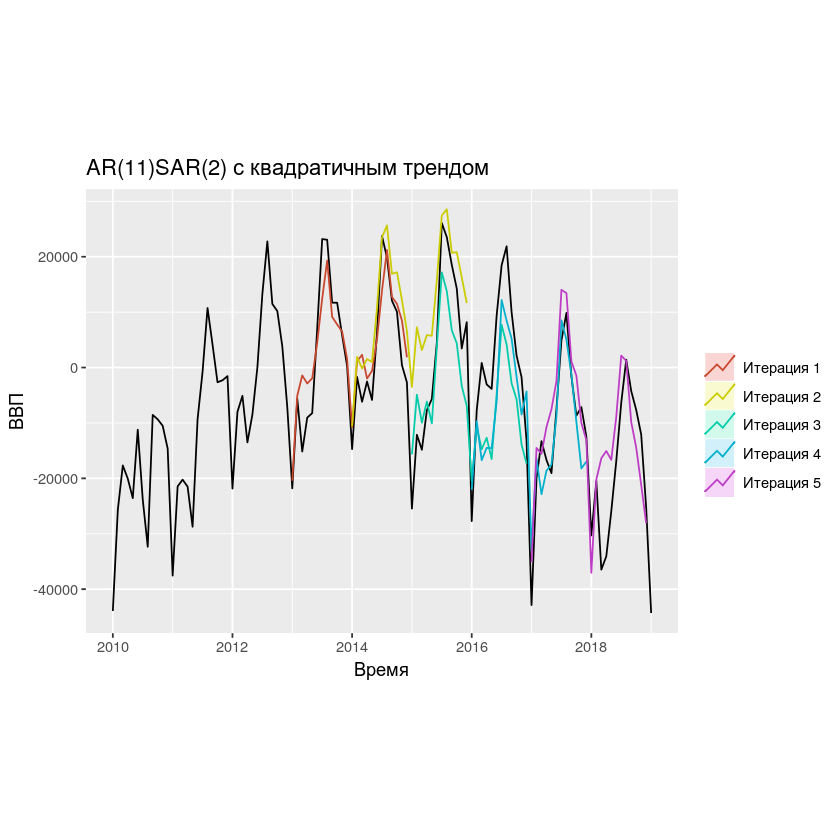

In [655]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ЕП') +
    ggtitle("AR(11)SAR(2) с квадратичным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [656]:
save_plots[[6]]  <- plot_forecasts

In [657]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0


In [658]:
l <- ac <- m_top  <- l_test  <-  list()
err_list  <- c()
k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
#         if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#             train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
#         }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
#     }
}
    
#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         test <- window(gdp_agg, start=test_start-var_topup/var_freq)
#     }else{    
        test <- window(gdp_agg, start=test_start, end=test_end)
        
#     }
    
    
    t <- 1:length(train)
    regressors <- cbind(trend=t,quad=t^2)
        
#     m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, xreg = regressors, include.drift = FALSE, include.mean = TRUE, method = "ML")
    
    t_f <- (length(train)+1):(length(train)+var_h)
    regressors_f <- cbind(trend=t_f,quad=t_f^2)
    
#     l[[k]]  <-   forecast(m_top[[k]], h = var_h, xreg = regressors_f  )

#     l_test[[i+1]]  <-   test
    
#     ac[[i+1]]  <-  accuracy(l[[k]], test)
    
#     }

    model  <-  tryCatch( list(Arima(train, order=c(11,0,0), seasonal=c(2,0,0), xreg = regressors, include.drift = FALSE, include.constant = TRUE, method = "ML") , 0), 
            error = function(e) 
               {tryCatch( list( Arima(train, order=c(11,0,0), seasonal=c(2,0,0), xreg = regressors, include.drift = FALSE, include.constant = TRUE, method = "CSS"), i+1), 
                         error = function(e)              
                            list( Arima(train, order=c(11,0,0), seasonal=c(2,0,0), xreg = regressors, include.drift = FALSE, include.constant = TRUE, method = "CSS", optim.method = "SANN"), i+1))
                         }
    )

    
    m_top[[k]]  <- model[[1]]
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h, xreg = regressors_f  )
                
    if (model[[2]]!=0){
        err_list <-  c(err_list,model[[2]])
    }              
                
                
    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
                
    progress(i, progress.bar = TRUE)
    
                
    }

          0%---------25%---------50%---------75%--------100%
Progress: ||||||||||||||||||||||||

In [659]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-1357.6421,5556.373,143.40085
-2860.2794,7116.148,189.05303
-4680.5345,8561.666,238.20639
-691.1693,6637.855,149.04325
-1015.9444,6524.626,148.22058
-991.4762,6821.851,144.30263
-4073.0987,7571.870,155.42791
-6358.0827,8756.751,186.94325
-5377.4869,8101.633,169.67124
-4935.9114,7811.730,163.89981


In [660]:
colMeans(df_acc_test)

ME       RMSE       MAPE 
-5096.3015 10035.5709   162.2623

In [661]:
df_1  <-  data.frame(l[[1]]$mean)
for (i in 2:length(l)){
    df_1  <- cbind(df_1, data.frame(l[[i]]$mean))
}

df_1  <- t(df_1)
colnames(df_1) <- seq(1:dim(df_1)[2])
rownames(df_1) <- seq(1:dim(df_1)[1])

In [662]:
save_fcsts[[2]] <- df_1

In [663]:
library(multDM)

In [667]:
list_dm <- list()
dm_stat  <-  c()
for (i in 1:dim(df_1)[2]){
    
    wind  <-  window(gdp_agg, start=(var_start_year + 1/var_freq*(var_window+i)), end=(var_start_year + 1/var_freq*(var_window+i-1+dim(df_1)[1])))
    
    list_dm[[i]]  <- DM.test(f1=save_fcsts[[1]][,i],f2=save_fcsts[[2]][,i],y=wind,loss.type="SPE",h=i,c=TRUE,H1="same")
    dm_stat  <-  c(dm_stat,list_dm[[i]][[1]][[1]])
}

Warning message in sqrt(gdk/T):
“NaNs produced”Warning message in sqrt(gdk/T):
“NaNs produced”Warning message in sqrt(gdk/T):
“NaNs produced”

In [673]:
dm_stat

[1]  0.10528958  1.13332095  0.80160337 -1.12083890  1.26482783  1.43112690
 [7] -0.19495436 -0.01803981 -2.23885873  0.86474627  2.20361420 -1.31871947
[13]  2.97456464 -0.75917455  3.28838891  2.63494051  1.33659304  4.87080627
[19] 12.30156789  3.79802607         NaN         NaN         NaN -5.17492356

In [669]:
data_dm  <- cbind(dm_stat, seq(1,var_h))

colnames(data_dm)  <-  c('DM','h')

data_dm  <- as.data.frame(data_dm)

In [670]:
var_col_test  <-  'red'

In [671]:
var_95 <- qt(c(.025, .975), df = dim(df_acc_test)[1] - 1)
var_90  <- qt(c(.05, .95), df = dim(df_acc_test)[1] - 1)

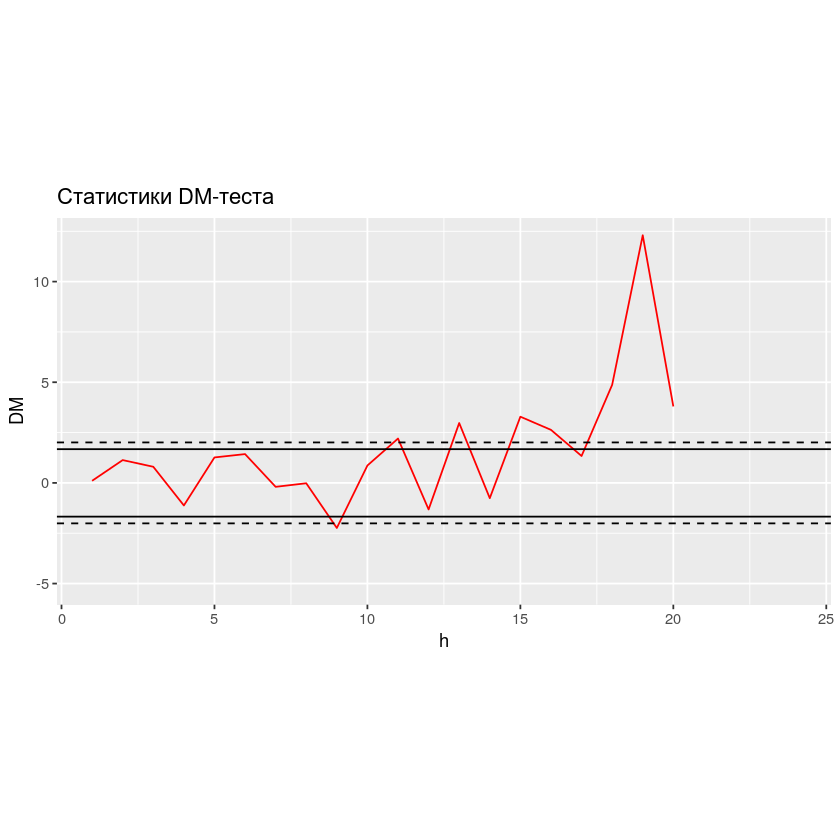

In [672]:
# plot_dm <- 

ggplot(data=data_dm, aes(x=h, y=DM)) +
            geom_line(colour=var_col_test) + labs(title = "Статистики DM-теста")  +
            theme(aspect.ratio = 0.5)+
            labs(y = "DM", x = 'h') +
            geom_hline(yintercept=var_95, linetype="dashed", color = "black") +
            geom_hline(yintercept=var_90,  color = "black") 
            

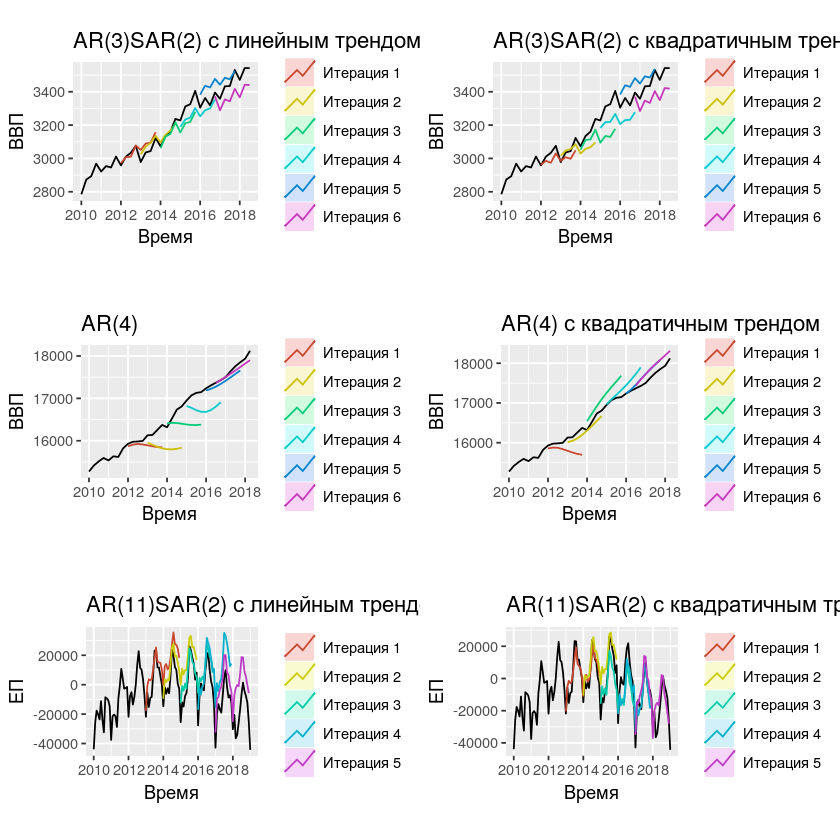

In [679]:
library(gridExtra)
grid.arrange(grobs = save_plots, ncol = 2)